In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle

from subprocess import call

import h5py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from lasagne import regularization

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
filename = 'Localized_N=300000_S=200_M=200_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Localized_N=300000_S=200_M=200_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [4]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.04975 -- accuracy=98.34%  
  valid loss:		0.00795
  valid accuracy:	0.99752+/-0.00259
  valid auc-roc:	0.99883+/-0.00223
  valid auc-pr:		0.94596+/-0.12922
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=300000_S=200_M=200_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.01008 -- accuracy=99.66%  
  valid loss:		0.00553
  valid accuracy:	0.99813+/-0.00206
  valid auc-roc:	0.99940+/-0.00099
  valid auc-pr:		0.96778+/-0.07155
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=300000_S=200_M=200_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.00875 -- accuracy=99.70%  
  valid loss:		0.00519
  valid accuracy:	0.99824+/-0.00193
  valid auc-roc:	0.99947+/-0.00087
  valid auc-pr:		0.97038+/-0.06627
saving model parameters to: /home/peter/Data/

In [5]:
nnmodel.print_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 4, 200, 1)
layer2: 
shape:(None, 32, 200, 1)
parameters: W
layer3: 
shape:(None, 32, 200, 1)
parameters: beta, gamma, mean, inv_std
layer4: 
shape:(None, 32, 200, 1)
layer5: 
shape:(None, 32, 10, 1)
layer6: 
shape:(None, 32, 10, 1)
layer7: 
shape:(None, 128, 1, 1)
parameters: W
layer8: 
shape:(None, 128, 1, 1)
parameters: beta, gamma, mean, inv_std
layer9: 
shape:(None, 128, 1, 1)
layer10: 
shape:(None, 128, 1, 1)
layer11: 
shape:(None, 20, 1, 1)
parameters: W
layer12: 
shape:(None, 20, 1, 1)
layer13: 
shape:(None, 20)
----------------------------------------------------------------------------


In [6]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.conv.Conv2DLayer at 0x7f6ac85120d0>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f6a6311b8d0>,
 'conv1_dropout': <lasagne.layers.noise.DropoutLayer at 0x7f6a6311ba90>,
 'conv1_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7f6ac8512110>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f6a6311ba50>,
 'conv2': <lasagne.layers.conv.Conv2DLayer at 0x7f6a6311bb50>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f6a63126250>,
 'conv2_dropout': <lasagne.layers.noise.DropoutLayer at 0x7f6a631263d0>,
 'conv2_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7f6a6311bb10>,
 'conv3': <lasagne.layers.conv.Conv2DLayer at 0x7f6a63126490>,
 'conv3_active': <lasagne.layers.special.NonlinearityLayer at 0x7f6a63126450>,
 'input': <lasagne.layers.input.InputLayer at 0x7f6ac850da90>,
 'output': <lasagne.layers.shape.ReshapeLayer at 0x7f6a631264d0>}

In [7]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [8]:
def maxunpool(X, pool, active):
    pool_size = active.shape[2]/pool.shape[2]
    fmap1 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k],axis=(2,))
        mymap = np.squeeze(pool[k],axis=(2,))

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap1.append(fmap_unpool)

    fmap1 = np.array(fmap1)
    fmap1 = np.expand_dims(fmap1, 3)
    return fmap1 

def deconvolution(fmap, layer):
    # psuedo-inverse filters
    W4 = layer.W.get_value()

    # deconvolution layer 2
    input_var4 = T.tensor4('conv4')
    shape4 = list(fmap.shape)
    shape4[0] = None
    input4 = InputLayer(shape=tuple(shape4), input_var=input_var4)
    #unpool4 = ExpressionLayer(input4, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    #unpool4 = BiasLayer(unpool4, b=-network['conv2_bias'].b)
    if layer.pad == 'valid':
        pad = 'full'
    else:
        pad = 'same'
    deconv4 = Conv2DLayer(input4, num_filters=layer.input_shape[1],
                                          filter_size=layer.filter_size,
                                          W=layer.W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad= 'full' if layer.pad==(0,0) else 'same',
                                          nonlinearity=None, flip_filters=False)
    predict = theano.function([input_var4], get_output(deconv4, deterministic=True), allow_input_downcast=True)

    intermediate = predict(fmap.astype(np.float32))
    return np.array(intermediate)

def get_feature_map_all(layer, input_var, X):
    get_map = theano.function([input_var], get_output(layer), allow_input_downcast=True)
    return get_map(X)

 
def activation_filter(layer, percentile, window=0, norm=0):
    pool = np.squeeze(layer[0], axis=2)
    if norm:
        pool = np.abs(pool)
        
    pool_flat = pool.reshape([-1,])
    num_data = len(pool_flat)
    cutoff = np.round(num_data*percentile).astype(int)
    threshold = np.sort(pool_flat)[-cutoff]

    if norm:
        sum_spikes = np.max(np.abs(pool),axis=0)
    else:
        sum_spikes = np.max(pool,axis=0)
        
    index = np.where(sum_spikes > threshold)[0]
    fmap = np.zeros(pool.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(pool.shape[1],i+window+1)
        fmap[:,MIN:MAX] = pool[:,MIN:MAX]
    fmap = np.expand_dims(fmap,0)
    fmap = np.expand_dims(fmap,3)
    return fmap, threshold

def max_filter(layer, percentile, window=0, norm=0):
    pool = np.squeeze(layer[0], axis=2)
    if norm:
        pool = np.abs(pool)
    max_pool = np.max(pool, axis=0)
    num_data = len(max_pool)
    cutoff = np.round(num_data*percentile).astype(int)
    threshold = np.sort(max_pool)[-cutoff]
    
    index = np.where(max_pool > threshold)[0]
    fmap = np.zeros(pool.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(pool.shape[1],i+window+1)
        fmap[:,MIN:MAX] = pool[:,MIN:MAX]
    fmap = np.expand_dims(fmap,0)
    fmap = np.expand_dims(fmap,3)
    return fmap, threshold

def same_unpool_fmap(layer, seq_length):
    activation = np.squeeze(layer[0], axis=2)
    num_channels, num_map = activation.shape

    num_unpool = np.floor(seq_length/num_map).astype(int)
    amap = np.zeros((num_channels, seq_length))
    for i in range(num_map):
        amap[:,range(i*num_unpool,(i+1)*num_unpool)] = np.outer(activation[:,i], np.ones(num_unpool))
    return amap

# Sensitivity analysis (single sequence)

In [86]:
map_index = 166#14, 16, 22
savename = 'Unlocalized_shallow_'+str(map_index)+'_'
savedir = '/home/peter/Documents/'+savename

X = test[0][map_index]
X = np.expand_dims(X,0)
y = test[1][map_index]
model = test[2][map_index]
print X.shape

seq_length = X.shape[2]

(1, 4, 200, 1)


In [87]:
# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
print 'ground truth = ' + str(np.argmax(y))
print 'prediction = ' + str(np.argmax(prediction))

class_index = np.argmax(y)

ground truth = 7
prediction = 7


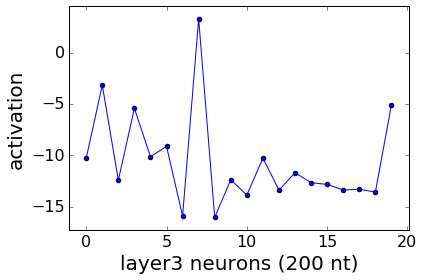

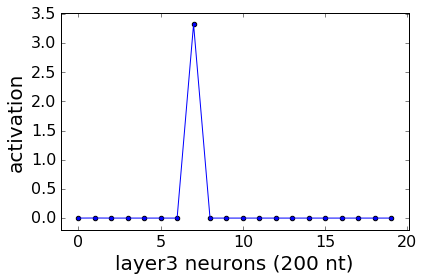

In [88]:
# get dense layer
get_conv3 = theano.function([nnmodel.input_var], layers.get_output(network['conv3'], deterministic=True), allow_input_downcast=True)
conv3 = get_conv3(X)
conv3_flat = np.squeeze(conv3[0],axis=2)


fig = plt.figure()
plt.plot(conv3_flat);
plt.scatter(range(20),conv3_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)


threshold = 0#np.max(conv3)*.9
#conv3[conv3<threshold] = 0

MAX = np.max(conv3)
conv3 = conv3/MAX*4
conv3 = np.exp(conv3)
conv3 = conv3/np.max(conv3)*MAX


conv3_flat = np.squeeze(conv3[0],axis=2)


fig = plt.figure()
plt.plot(conv3_flat);
plt.scatter(range(20),conv3_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)

In [89]:
#conv3 = np.ones(20)*0
#conv3[class_index]=20
#conv3 = np.expand_dims(conv3,0)
#conv3 = np.expand_dims(conv3,2)
#conv3 = np.expand_dims(conv3,3)



0

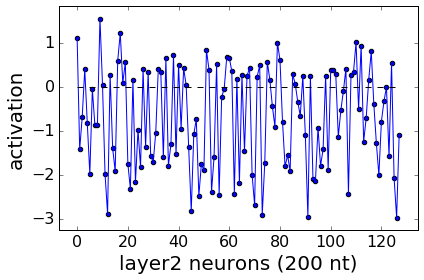

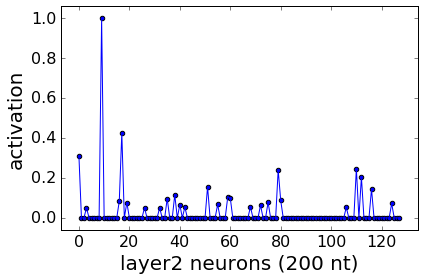

In [90]:
# get dense layer
#get_conv2 = theano.function([nnmodel.input_var], layers.get_output(network['conv2'], deterministic=True), allow_input_downcast=True)
#conv2 = get_conv2(X)
conv2 = deconvolution(conv3, network['conv3'])
conv2_flat = np.squeeze(conv2[0],axis=2)


fig = plt.figure()
plt.plot(conv2_flat);
plt.scatter(range(len(conv2_flat)),conv2_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)


threshold = 0#np.max(conv2)*.8
#conv2[conv2<threshold] = .0
MAX = np.max(conv2)
conv2 = conv2/MAX*4
conv2 = np.exp(conv2)
conv2 =conv2/np.max(conv2)
conv2[conv2<0.05] = 0

plt.plot(range(len(conv2_flat)), np.ones(len(conv2_flat))*threshold, color='k', linestyle='--')
outfile = savedir+ 'deconv2_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

conv2_flat = np.squeeze(conv2[0],axis=2)
fig = plt.figure()
plt.plot(conv2_flat);
plt.scatter(range(len(conv2_flat)),conv2_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'deconv2_filter_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])


0

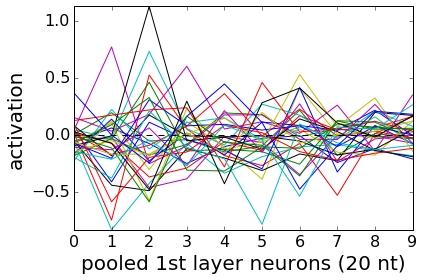

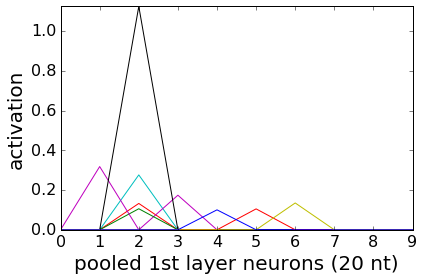

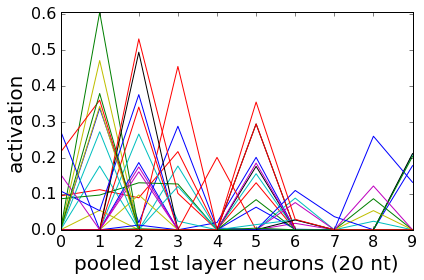

In [91]:

conv1_pool = deconvolution(conv2, network['conv2'])
pool = np.squeeze(conv1_pool[0])

fig = plt.figure()
plt.plot(pool.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (20 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)


threshold = 0#np.max(conv1_pool)*.5
#conv1_pool[conv1_pool<threshold] = .0
MAX = np.max(conv1_pool)
conv1_pool = conv1_pool/MAX*4
conv1_pool = np.exp(conv1_pool)
conv1_pool = conv1_pool/np.max(conv1_pool)*MAX
conv1_pool[conv1_pool<0.1] = 0

plt.plot(range(pool.shape[1]), np.ones(pool.shape[1])*threshold, color='k', linestyle='--')
outfile = savedir+ 'deconv1_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

fig = plt.figure()
plt.plot(np.squeeze(conv1_pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (20 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'deconv1_filter_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])


pool = get_feature_map_all(network['conv1_pool'], nnmodel.input_var, X)
fig = plt.figure()
plt.plot(np.squeeze(pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (20 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'conv1pool_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])





0

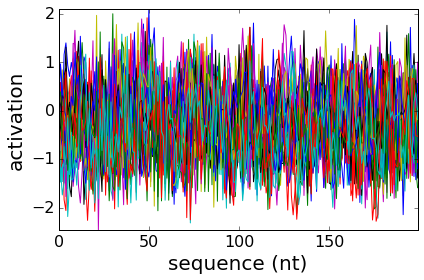

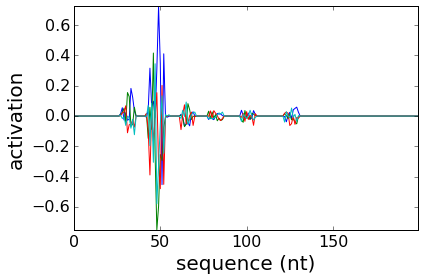

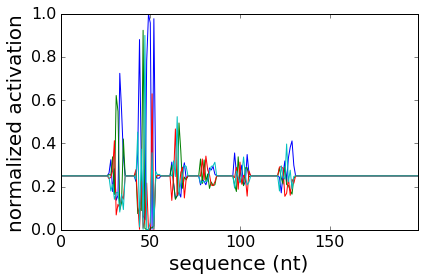

In [92]:
conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
conv1 = maxunpool(X, conv1_pool, conv1_active)
reconstruction = deconvolution(conv1, network['conv1'])
fig = plt.figure()
plt.plot(np.squeeze(conv1_active[0]).T)
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'conv1_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])


fig = plt.figure()
plt.plot(np.squeeze(reconstruction[0]).T)
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
outfile = savedir+ 'deconv0_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

#reconstruction[reconstruction<0]=0

pwm = np.squeeze(reconstruction[0])
MAX = np.max(pwm)
#pwm[pwm<0] = 0
pwm = pwm/MAX*6
pwm = np.exp(pwm)
pwm = pwm/np.max(pwm)
#pwm += .2
#pwm[pwm<0] = 0
#pwm = pwm + np.mean(pwm)
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm

fig = plt.figure()
plt.plot(pwm.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('normalized activation', fontsize=20)
outfile = savedir+ 'deconv0_normalized_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

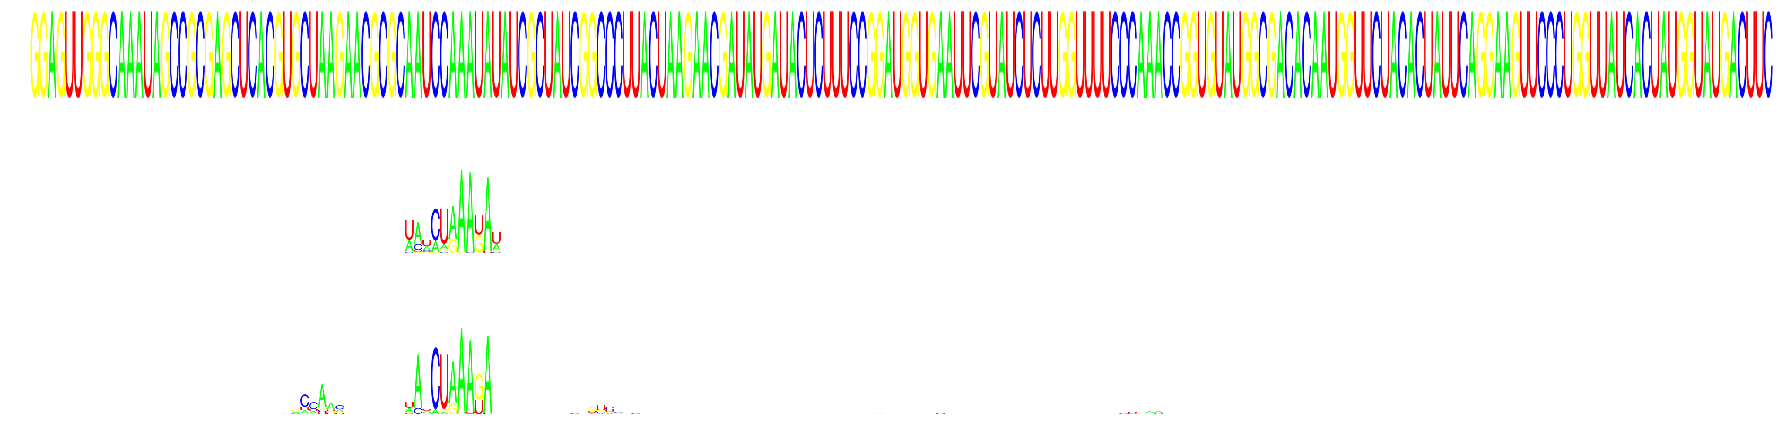

In [93]:
height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(3,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(3,1,2)
logo = seq_logo(model, height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(3,1,3)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');
outfile = savedir+ 'reconstructed_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  


In [ ]:

def importance_segmentation(X, network, input_var):
    get_conv3 = theano.function([input_var], layers.get_output(network['conv3'], deterministic=True), allow_input_downcast=True)
    conv3 = get_conv3(X)
    conv3_flat = np.squeeze(conv3[0],axis=2)

    conv2 = deconvolution(conv3, network['conv3'])
    conv2_flat = np.squeeze(conv2[0],axis=2)

    conv1_pool = deconvolution(conv2, network['conv2'])
    pool = np.squeeze(conv1_pool[0])

    conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
    conv1 = maxunpool(X, conv1_pool, conv1_active)
    reconstruction = deconvolution(conv1, network['conv1'])

    pwm = np.squeeze(reconstruction[0])
    pwm = pwm/np.max(pwm)
    pwm += .2
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    return conv3_flat, conv2_flat, pool


conv3 = []
conv2 = []
conv1 = []
for i in range(10000):
    X = train[0][i]
    X = np.expand_dims(X,0)
    conv3_flat, conv2_flat, conv1_pool = importance_segmentation(X, network, nnmodel.input_var)
    conv3.append(conv3_flat[0])
    conv2.append(conv2_flat[0])
    conv1.append(conv1_pool[0])
    
conv1 = np.array(conv1)
conv2 = np.array(conv2)
conv2 = np.array(conv3)


In [ ]:

conv1 = np.array(conv1)
conv2 = np.array(conv2)
conv3 = np.array(conv3)


In [ ]:
mean_conv1 = np.mean(conv1,axis=0)
std_conv1 = np.std(conv1,axis=0)
mean_conv2 = np.mean(conv2,axis=0)
std_conv2 = np.std(conv2,axis=0)
mean_conv3 = np.mean(conv3,axis=0)
std_conv3 = np.std(conv3,axis=0)

In [ ]:
plt.plot(std_conv1)

In [ ]:
conv1_thresh = mean_conv1+std_conv1
conv2_thresh = mean_conv2+std_conv2
conv3_thresh = mean_conv3+std_conv3
def importance_segmentation(X, network, input_var, conv1_thresh, conv2_thresh, conv3_thresh):
    get_conv3 = theano.function([input_var], layers.get_output(network['conv3'], deterministic=True), allow_input_downcast=True)
    conv3 = get_conv3(X)
    conv3_flat = np.squeeze(conv3[0],axis=2)

    conv2 = deconvolution(conv3, network['conv3'])
    conv2_flat = np.squeeze(conv2[0],axis=2)
    
    conv1_pool = deconvolution(conv2, network['conv2'])
    pool = np.squeeze(conv1_pool[0])

    conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
    conv1 = maxunpool(X, conv1_pool, conv1_active)
    reconstruction = deconvolution(conv1, network['conv1'])

    pwm = np.squeeze(reconstruction[0])
    pwm = pwm/np.max(pwm)
    pwm += .2
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    return conv3_flat, conv2_flat, conv1_pool


In [ ]:
# get dense layer
get_conv2 = theano.function([nnmodel.input_var], layers.get_output(network['conv2'], deterministic=True), allow_input_downcast=True)
conv2 = get_conv2(X)

plt.figure()
plt.plot(np.squeeze(conv2[0]));
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('2nd layer neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)

conv1_pool = deconvolution(conv2, network['conv2'])

plt.figure()
plt.plot(np.squeeze(conv1_pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (20 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)

conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
conv1 = maxunpool(X, conv1_pool, conv1_active)
reconstruction = deconvolution(conv1, network['conv1'])

plt.figure()
plt.plot(np.squeeze(reconstruction[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)


pwm = np.squeeze(reconstruction[0])
pwm = pwm/np.max(pwm)
pwm += .33
pwm[pwm<0] = 0
#pwm = pwm + np.mean(pwm)
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm


plt.figure()
plt.plot(pwm.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('normalized activation', fontsize=20)


height=100
bp_width=20
size = (25.,10.0)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
outfile = savedir+ 'reconstruct_nothresh_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

In [ ]:

def deconvolve_activation(X, network, nnmodel):

    get_conv4pool = theano.function([nnmodel.input_var], layers.get_output(network['conv4_active'], deterministic=True), allow_input_downcast=True)
    conv4_pool = get_conv4pool(X)
    conv4_pool, threshold = activation_filter(conv4_pool, percentile=0.15, window=0, norm=0)

    conv3_pool = deconvolution(conv4_pool, network['conv4'])
    conv3_pool, threshold = activation_filter(conv3_pool, percentile=0.1, window=0, norm=0)
    conv3_pool[conv3_pool < threshold*1] = 0
    conv3_active = get_feature_map_all(network['conv3_active'], nnmodel.input_var, X)
    conv3 = maxunpool(X, conv3_pool, conv3_active)

    conv2_pool = deconvolution(conv3, network['conv3'])
    conv2_pool, threshold = activation_filter(conv2_pool, percentile=0.03, window=0, norm=0)
    conv2_pool[conv2_pool < threshold*.8] = 0
    conv2_active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
    conv2 = maxunpool(X, conv2_pool, conv2_active)
    
    conv1_pool = deconvolution(conv2, network['conv2'])
    conv1_pool, threshold = activation_filter(conv1_pool, percentile=0.005, window=0, norm=1)
    conv1_pool[conv1_pool < threshold*.8] = 0
    conv1_active = get_feature_map_all(network['conv1_active'], nnmodel.input_var, X)
    conv1 = maxunpool(X, conv1_pool, conv1_active)

    reconstruction = deconvolution(conv1, network['conv1'])

    pwm = np.squeeze(reconstruction[0])
    pwm = pwm/np.max(pwm)
    pwm += .25
    pwm[pwm<0] = 0
    #pwm += np.mean(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm

    return pwm


In [ ]:
datadir = '/home/peter/Data/SequenceMotif'
savedir = make_directory(datadir, 'classification')

X_test = np.copy(test[0])
y_test = np.copy(test[1])
labels = np.argmax(y_test,axis=1)
model = np.copy(test[2])

get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['dense'], deterministic=True), allow_input_downcast=True)

for class_index in range(20):

    map_index = np.where(labels == class_index)[0]

    score = []
    for i in map_index:
        prediction = get_prediction(np.expand_dims(X_test[i],0))
        score.append(prediction[0][class_index])
    score = np.array(score)

    top_hits = 20
    top_index = np.argsort(score)[::-1]
    tophits_index = map_index[top_index[:top_hits]]
    print score[top_index[:top_hits]]


    for index in tophits_index:

        X = np.copy(np.expand_dims(X_test[index],0))
        class_index = np.argmax(y_test[index,:])
        prediction = np.argmax(get_prediction(X))

        height=100
        bp_width=20
        size = (25.,10.0)

        logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
        fig = plt.figure(figsize=size);
        plt.imshow(logo, interpolation='none');
        plt.axis('off');
        outfile = os.path.join(savedir,'top-class_sequence_'+ str(class_index)  + '_' + str(index) +'.pdf')
        fig.savefig(outfile, format='pdf', dpi=1000)  
        call(['pdfcrop', outfile, outfile])


        logo = seq_logo(model[index], height, bp_width, norm=0, rna=1, filepath='.')
        fig = plt.figure(figsize=size);
        plt.imshow(logo, interpolation='none');
        plt.axis('off');
        plt.title(str(class_index),fontsize=20)
        outfile = os.path.join(savedir,'top-class_model_'+ str(class_index)  + '_' + str(index) +'.pdf')
        fig.savefig(outfile, format='pdf', dpi=1000)  
        call(['pdfcrop', outfile, outfile])

        pwm = deconvolve_activation(X, network, nnmodel)
        logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
        fig = plt.figure(figsize=size);
        plt.imshow(logo, interpolation='none');
        plt.axis('off');
        plt.title(str(prediction),fontsize=20)
        outfile = os.path.join(savedir,'top-class_reconstruct_'+ str(class_index)  + '_' + str(index) +'.pdf')
        fig.savefig(outfile, format='pdf', dpi=1000)  
        call(['pdfcrop', outfile, outfile])


In [ ]:
# get dense layer
get_conv2pool = theano.function([nnmodel.input_var], layers.get_output(network['conv2'], deterministic=True), allow_input_downcast=True)
conv4_pool = get_conv2pool(X)
pool = np.squeeze(conv2_pool[0],axis=2)
plt.plot(pool);


#conv4_pool -= mean4

conv2_pool, threshold = activation_filter(conv4_pool, percentile=0.15, window=0, norm=0)
print threshold

#index = np.where(conv4_pool > 0)[0]
#conv4_pool[index] += mean4[index]

#threshold = 0
#conv4_pool[conv4_pool < threshold] = 0
pool = np.squeeze(conv4_pool[0],axis=2)
plt.plot(pool);
plt.plot(range(pool.shape[0]),np.ones(pool.shape[0])*threshold,color='r')

In [ ]:
def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

In [ ]:
conv3_pool = deconvolution(conv4_pool, network['conv4'])
pool = np.squeeze(conv3_pool[0])
#|pool = pool.reshape([-1,])
plt.plot(pool.T);

In [ ]:
conv3_pool = deconvolution(conv4_pool, network['conv4'])
#mean = np.mean(np.mean(conv3_all,axis=0),axis=1)
#conv3_pool = np.squeeze(conv3_pool[0]) - np.outer(mean,4)
#conv3_pool = np.expand_dims(conv3_pool,0)
#conv3_pool = np.expand_dims(conv3_pool,3)

pool = np.squeeze(conv3_pool[0])
pool = pool.reshape([-1,])
plt.plot(pool);

conv3_pool, threshold = activation_filter(conv3_pool, percentile=0.1, window=0, norm=0)
#print threshold
#threshold = 0
conv3_pool[conv3_pool < threshold*.8] = 0
plt.plot(range(len(pool)),np.ones(len(pool))*threshold,color='r')

In [ ]:
pool = get_feature_map_all(network['conv3_pool'], nnmodel.input_var, X)

original_map = same_unpool_fmap(pool, seq_length)
plt.figure()
plt.imshow(original_map)
plt.colorbar()


amap3 = same_unpool_fmap(conv3_pool, seq_length)
plt.figure()
plt.imshow(amap3)
plt.colorbar()


In [ ]:
conv3_active = get_feature_map_all(network['conv3_active'], nnmodel.input_var, X)
conv3 = maxunpool(X, conv3_pool, conv3_active)
conv2_pool = deconvolution(conv3, network['conv3'])

#mean = np.mean(np.mean(conv2_all,axis=0),axis=1)
#conv2_pool = np.squeeze(conv2_pool[0]) - np.outer(mean,4)
#conv2_pool = np.expand_dims(conv2_pool,0)
#conv2_pool = np.expand_dims(conv2_pool,3)


pool = np.squeeze(conv2_pool[0])
plt.plot(pool.T);

conv2_pool, threshold = activation_filter(conv2_pool, percentile=0.02, window=0, norm=0)
#print threshold
#conv2_pool[conv2_pool < threshold/2] = 0
conv2_pool[conv2_pool < threshold*1.0] = 0

plt.plot(range(pool.shape[1]),np.ones(pool.shape[1])*threshold,color='r')

In [ ]:
pool = get_feature_map_all(network['conv2_pool'], nnmodel.input_var, X)

original_map = same_unpool_fmap(pool, seq_length)
plt.figure()
plt.imshow(original_map)
plt.colorbar()


amap2 = same_unpool_fmap(conv2_pool, seq_length)
plt.figure()
plt.imshow(amap2)
plt.colorbar()


In [ ]:
conv2_active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
conv2 = maxunpool(X, conv2_pool, conv2_active)
conv1_pool = deconvolution(conv2, network['conv2'])


pool = np.squeeze(conv1_pool[0])
plt.plot(pool.T);

conv1_pool, threshold = activation_filter(conv1_pool, percentile=0.005, window=0, norm=0)
#print threshold
#threshold = 0
conv1_pool[conv1_pool < threshold*1] = 0

plt.plot(range(pool.shape[1]),np.ones(pool.shape[1])*threshold,color='r')


In [ ]:
pool = get_feature_map_all(network['conv1_pool'], nnmodel.input_var, X)

original_map = same_unpool_fmap(pool, seq_length)
plt.figure()
plt.imshow(original_map)
plt.colorbar()


amap1 = same_unpool_fmap(conv1_pool, seq_length)
plt.figure()
plt.imshow(amap1)
plt.colorbar()



In [ ]:

conv1_pool = deconvolution(conv2, network['conv2'])
pool = np.squeeze(conv1_pool[0])

pool = np.abs(pool)
pool /= np.max(pool)*1.2

plt.figure()
plt.plot(pool.T);
plt.axis('tight')

entropy = np.sum(-pool*np.log2(pool),axis=0)/np.log(2)
plt.figure()
plt.plot(entropy)


In [ ]:
conv1_active = get_feature_map_all(network['conv1_active'], nnmodel.input_var, X)
conv1 = maxunpool(X, conv1_pool, conv1_active)
reconstruction = deconvolution(conv1, network['conv1'])

plt.figure()
plt.plot(np.squeeze(reconstruction[0]).T)

#reconstruction[reconstruction<0]=0

pwm = np.squeeze(reconstruction[0])
pwm = pwm/np.max(pwm)
pwm += .25
pwm[pwm<0] = 0
#pwm = pwm + np.mean(pwm)
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm

plt.figure()
plt.plot(pwm.T);

In [ ]:
height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');

logo = seq_logo(model, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
#plt.title(str(y),fontsize=20)

logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');


In [ ]:

def deconvolve_activation(X, network, nnmodel, mean4):


    get_conv4pool = theano.function([nnmodel.input_var], layers.get_output(network['conv4_active'], deterministic=True), allow_input_downcast=True)
    conv4_pool = get_conv4pool(X)
    conv4_pool, threshold = activation_filter(conv4_pool, percentile=0.15, window=0, norm=0)

    conv3_pool = deconvolution(conv4_pool, network['conv4'])
    conv3_pool, threshold = activation_filter(conv3_pool, percentile=0.1, window=0, norm=0)
    conv3_pool[conv3_pool < threshold*1] = 0
    conv3_active = get_feature_map_all(network['conv3_active'], nnmodel.input_var, X)
    conv3 = maxunpool(X, conv3_pool, conv3_active)

    conv2_pool = deconvolution(conv3, network['conv3'])
    conv2_pool, threshold = activation_filter(conv2_pool, percentile=0.03, window=0, norm=0)
    conv2_pool[conv2_pool < threshold*1] = 0
    conv2_active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
    conv2 = maxunpool(X, conv2_pool, conv2_active)
    
    conv1_pool = deconvolution(conv2, network['conv2'])
    conv1_pool, threshold = activation_filter(conv1_pool, percentile=0.005, window=0, norm=1)
    conv1_pool[conv1_pool < threshold*.8] = 0
    conv1_active = get_feature_map_all(network['conv1_active'], nnmodel.input_var, X)
    conv1 = maxunpool(X, conv1_pool, conv1_active)

    reconstruction = deconvolution(conv1, network['conv1'])

    pwm = np.squeeze(reconstruction[0])
    pwm = pwm/np.max(pwm)
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm

    return pwm


In [ ]:
class_index = 3

labels = np.argmax(test[1],axis=1)
map_index = np.where(labels == class_index)[0]

get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
    
for index in map_index[:5]:

    X = np.expand_dims(test[0][index],0)
    class_index = np.argmax(test[1][index,:])
    prediction = np.argmax(get_prediction(X))

    height=100
    bp_width=20
    size = (25.,10.0)

    logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(class_index),fontsize=20)

    pwm = deconvolve_activation(X, network, nnmodel)
    logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(prediction),fontsize=20)
    
    

In [ ]:
# get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
    
map_index = range(100,120)
for index in map_index:

    X = np.expand_dims(test[0][index],0)
    class_index = np.argmax(test[1][index,:])
    prediction = np.argmax(get_prediction(X))

    height=100
    bp_width=20
    size = (25.,10.0)

    logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(class_index),fontsize=20)

    pwm = deconvolve_activation(X, network, nnmodel, mean4)
    logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(prediction),fontsize=20)

# activation inversion to get pwm

In [ ]:
conv1_active = get_feature_map_all(network['conv1_active'], nnmodel.input_var, X)
activation = np.squeeze(conv1_active[0])




In [ ]:
input_var2 = T.dmatrix('inputs')
net_filter = {}
net_filter['input'] = InputLayer(filter_size, input_var=input_var2)
net_filter['output']  = Conv2DLayer(net_filter['input'], num_filters=1,
                                          filter_size=filter_size,
                                          W=init.GlorotUniform()
                                          b=None,
                                          pad='valid',
                                          nonlinearity=None, flip_filters=False)

target_var2 = T.dvector('seq')
prediction = layers.get_output(net_filter['output'], deterministic=True)
loss = objectives.squared_error(target_var2, prediction)
loss = objectives.aggregate(loss, mode='mean')

params = layers.get_all_params(deconv['output'], trainable=True)  
grad = T.grad(loss, params)

update_op = updates.adam(grad, params, learning_rate=0.001)
train_fun = theano.function([input_var2, target_var2], loss, updates=update_op, allow_input_downcast=True)

In [ ]:
for epoch in range(200):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))
    loss = train_fun(W,activation)
    sys.stdout.write("\r  loss = %f \n"%(loss))


# try to learn optimal thresholds

In [ ]:
from lasagne.layers import InverseLayer, ExpressionLayer, NonlinearityLayer

In [ ]:

def get_feature_maps(layer, nnmodel, X):
    feature_maps = theano.function([nnmodel.input_var], layers.get_output(layer, deterministic=True), 
                                   allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size = 256
    num_data = len(X)
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    index = range(num_data-excess, num_data)    
    fmaps[index] = feature_maps(X[index])
    return fmaps

X = train[0]
#fmaps4 = get_feature_maps(network['conv4_active'], nnmodel, X)
#fmaps3 = get_feature_maps(network['conv3_active'], nnmodel, X)
#fmaps2 = get_feature_maps(network['conv2_active'], nnmodel, X)
#fmaps1 = get_feature_maps(network['conv1_active'], nnmodel, X)

In [ ]:
shape2 = list(fmaps.shape)
shape2[0]=None
shape2 = tuple(shape2)

In [ ]:
input_var2 = T.tensor4('inputs')
deconv = {}
deconv['input'] = InputLayer(tuple(shape2), input_var=input_var2)

deconv['invconv4']  = Conv2DLayer(deconv['input'], num_filters=network['conv4'].input_shape[1],
                                          filter_size=network['conv4'].filter_size,
                                          W=network['conv4'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(-.0),
                                          pad='full' if network['conv4'].pad==(0,0) else 'same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)
deconv['invconv4'].params[deconv['invconv4'].W].remove('trainable')

deconv['invconv3_pool'] = layers.Upscale2DLayer(deconv['invconv4'], network['conv3_pool'].pool_size)
deconv['invconv3']  = Conv2DLayer(deconv['invconv3_pool'], num_filters=network['conv3'].input_shape[1],
                                          filter_size=network['conv3'].filter_size,
                                          W=network['conv3'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(-0.0), 
                                          pad='full' if network['conv3'].pad==(0,0) else 'same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)
deconv['invconv3'].params[deconv['invconv3'].W].remove('trainable')

deconv['invconv2_pool'] = layers.Upscale2DLayer(deconv['invconv3'], network['conv2_pool'].pool_size)
deconv['invconv2']  = Conv2DLayer(deconv['invconv2_pool'], num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(-0.0), 
                                          pad='full' if network['conv2'].pad==(0,0) else 'same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)
deconv['invconv2'].params[deconv['invconv2'].W].remove('trainable')

deconv['invconv1_pool'] = layers.Upscale2DLayer(deconv['invconv2'], network['conv1_pool'].pool_size)
deconv['invconv1']  = Conv2DLayer(deconv['invconv1_pool'], num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(-0.0), 
                                          pad='full' if network['conv1'].pad==(0,0) else 'same',
                                          nonlinearity=None, flip_filters=True)
deconv['invconv1'].params[deconv['invconv1'].W].remove('trainable')
deconv['output'] = ExpressionLayer(deconv['invconv1'], lambda X: X/T.max(X) + .25, output_shape='auto')
deconv['output'] = NonlinearityLayer(deconv['output'], nonlinearity=nonlinearities.rectify)
deconv['output'] = ExpressionLayer(deconv['output'], lambda X: X/T.shape_padaxis(T.tile(T.sum(X,axis=1),4).transpose([0,2,1]),3), output_shape='auto')

#offset = T.mean(X, axis=(1,2,3))
#scale = 0#T.sum(input_var3, axis=(1))
#scale = T.tile(norm,4).transpose([0,2,1])
#deconv['output'] = layers.standardize(deconv['output'], offset, scale, shared_axes=0)

In [ ]:
target_var3 = T.tensor4('inputs3')
target_var2 = T.tensor4('inputs2')
target_var1 = T.tensor4('inputs1')
target_var0 = T.tensor4('seq') 

prediction = layers.get_output(deconv['output'], deterministic=False)
loss = objectives.squared_error(target_var0, prediction)
loss = objectives.aggregate(loss)
loss = objectives.aggregate(loss, mode='mean')

recon3 = layers.get_output(deconv['invconv3_pool'], deterministic=False)
loss3 = objectives.squared_error(target_var3, recon3)
loss3 = objectives.aggregate(loss3, mode='mean')

recon2 = layers.get_output(deconv['invconv2_pool'], deterministic=False)
loss2 = objectives.squared_error(target_var2, recon2)
loss2 = objectives.aggregate(loss2, mode='mean')

recon1 = layers.get_output(deconv['invconv1_pool'], deterministic=False)
loss1 = objectives.squared_error(target_var1, recon1)
loss1 = objectives.aggregate(loss1, mode='mean')

loss = loss + loss3 + loss2 + loss1

def pos(x):
    return T.sum(-T.abs_(x-.25))
penalty = regularization.apply_penalty(params, pos)*.1
loss = loss + penalty


params = layers.get_all_params(deconv['output'], trainable=True)    
grad = T.grad(loss, params)

update_op = updates.adam(grad, params, learning_rate=0.001)
train_fun = theano.function([input_var2, target_var0, target_var1, target_var2, target_var3], 
                            loss, updates=update_op, allow_input_downcast=True)

In [ ]:
def batch_generator2(x1, x2, x3, x4, x5, batch_size=128):
    for start_idx in range(0, len(x1)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield x1[excerpt].astype(np.float32), x2[excerpt].astype(np.float32), x3[excerpt].astype(np.float32), x4[excerpt].astype(np.float32), x5[excerpt].astype(np.float32)


batch_size = 128            
for epoch in range(200):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    num_batches = train[0].shape[0] // batch_size
    batches = batch_generator2(fmaps4, train[0], fmaps1, fmaps2, fmaps3, batch_size)
    value = 0
    for i in range(num_batches):
        x1, x2, x3, x4, x5 = next(batches)
        loss = train_fun(x1, x2, x3, x4, x5)
        value += np.mean(loss)
    sys.stdout.write("\r  loss = %f \n"%(value/num_batches))


In [ ]:

target_var2 = T.tensor4('seq')
prediction = layers.get_output(deconv['output'], deterministic=True)
loss = objectives.squared_error(target_var2, prediction)
loss = objectives.aggregate(loss, mode='mean')

params = layers.get_all_params(deconv['output'], trainable=True)  

def pos(x):
    return T.sum(-T.abs_(x-.25))
penalty = regularization.apply_penalty(params, pos)*1.
loss = loss + penalty
    
grad = T.grad(loss, params)

update_op = updates.adam(grad, params, learning_rate=0.001)
train_fun = theano.function([input_var2, target_var2], [loss, prediction], updates=update_op, allow_input_downcast=True)

In [ ]:
def batch_generator2(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)


batch_size = 128            
for epoch in range(200):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    num_batches = train[0].shape[0] // batch_size
    batches = batch_generator2(fmaps, train[0], batch_size)
    value = 0
    for i in range(num_batches):
        X,y = next(batches)
        loss = train_fun(X,y)
        value += np.mean(loss[0])
    sys.stdout.write("\r  loss = %f \n"%(value/num_batches))


In [ ]:
index = 1

X = np.expand_dims(test[0][index],0)    
class_index = np.argmax(test[1][index,:])
model = test[2][index]

finput = feature_maps(np.expand_dims(test[0][index],0))
test_fun = theano.function([input_var2], get_output(deconv['output']), allow_input_downcast=True)
prediction = test_fun(finput)
pwm = np.squeeze(prediction[0])                           

height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');

logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(class_index),fontsize=20)

                           
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');

In [ ]:
pwm.T

# End-to-end deconvolution

In [ ]:
input_var2 = T.tensor4('inputs')
deconv = {}
deconv['input'] = InputLayer(tuple(shape), input_var=input_var2)

# 1st convolutional layer
deconv['conv1']  = Conv2DLayer(deconv['input'], num_filters=network['conv1'].num_filters,
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W,
                                          b=None, 
                                          pad=network['conv1'].pad,
                                          nonlinearity=None, flip_filters=False)
deconv['conv1_norm'] = BatchNormLayer(deconv['conv1_bias'], beta=network['conv1_batch'].beta, 
                                                            gamma=network['conv1_batch'].gamma, 
                                                            mean=network['conv1_batch'].mean, 
                                                            inv_std=network['conv1_batch'].inv_std)
deconv['conv1_active'] = layers.ParametricRectifierLayer(deconv['conv1_norm'], 
                                                         alpha=network['conv1_active'].alpha)
deconv['conv1'].params[deconv['conv1'].W].remove('trainable')
deconv['conv1_norm'].params[deconv['conv1_norm'].beta].remove('trainable')
deconv['conv1_norm'].params[deconv['conv1_norm'].gamma].remove('trainable')
deconv['conv1_active'].params[deconv['conv1_active'].alpha].remove('trainable')
deconv['conv1_pool'] = MaxPool2DLayer(deconv['conv1_active'], pool_size=network['conv1_pool'].pool_size)

# 2nd convolutional layer
deconv['conv2']  = Conv2DLayer(deconv['conv1_pool'], num_filters=network['conv2'].num_filters,
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W,
                                          b=None, 
                                          pad=network['conv2'].pad,
                                          nonlinearity=None, flip_filters=False)
deconv['conv2_norm'] = BatchNormLayer(deconv['conv2_bias'], beta=network['conv2_batch'].beta, 
                                                            gamma=network['conv2_batch'].gamma, 
                                                            mean=network['conv2_batch'].mean, 
                                                            inv_std=network['conv2_batch'].inv_std)
deconv['conv2_active'] = layers.ParametricRectifierLayer(deconv['conv2_norm'], 
                                                         alpha=network['conv2_active'].alpha)
deconv['conv2'].params[deconv['conv2'].W].remove('trainable')
deconv['conv2_norm'].params[deconv['conv2_norm'].beta].remove('trainable')
deconv['conv2_norm'].params[deconv['conv2_norm'].gamma].remove('trainable')
deconv['conv2_active'].params[deconv['conv2_active'].alpha].remove('trainable')
deconv['conv2_pool'] = MaxPool2DLayer(deconv['conv2_active'], pool_size=network['conv2_pool'].pool_size)

# 3rd convolutional layer
deconv['conv3']  = Conv2DLayer(deconv['conv2_pool'], num_filters=network['conv3'].num_filters,
                                          filter_size=network['conv3'].filter_size,
                                          W=network['conv3'].W,
                                          b=None, 
                                          pad=network['conv3'].pad,
                                          nonlinearity=None, flip_filters=False)
deconv['conv3_norm'] = BatchNormLayer(deconv['conv3_bias'], beta=network['conv3_batch'].beta, 
                                                            gamma=network['conv3_batch'].gamma, 
                                                            mean=network['conv3_batch'].mean, 
                                                            inv_std=network['conv3_batch'].inv_std)
deconv['conv3_active'] = layers.ParametricRectifierLayer(deconv['conv3_norm'], 
                                                         alpha=network['conv3_active'].alpha)
deconv['conv3'].params[deconv['conv3'].W].remove('trainable')
deconv['conv3_norm'].params[deconv['conv3_norm'].beta].remove('trainable')
deconv['conv3_norm'].params[deconv['conv3_norm'].gamma].remove('trainable')
deconv['conv3_active'].params[deconv['conv3_active'].alpha].remove('trainable')
deconv['conv3_pool'] = MaxPool2DLayer(deconv['conv3_active'], pool_size=network['conv3_pool'].pool_size)

# 4th convolutional layer
deconv['conv4']  = Conv2DLayer(deconv['conv3_pool'], num_filters=network['conv4'].num_filters,
                                          filter_size=network['conv4'].filter_size,
                                          W=network['conv4'].W,
                                          b=None, 
                                          pad=network['conv4'].pad,
                                          nonlinearity=None, flip_filters=False)
deconv['conv4_norm'] = BatchNormLayer(deconv['conv4_bias'], beta=network['conv4_batch'].beta, 
                                                            gamma=network['conv4_batch'].gamma, 
                                                            mean=network['conv4_batch'].mean, 
                                                            inv_std=network['conv4_batch'].inv_std)
deconv['conv4_active'] = layers.ParametricRectifierLayer(deconv['conv4_norm'], 
                                                         alpha=network['conv4_active'].alpha)
deconv['conv4'].params[deconv['conv4'].W].remove('trainable')
deconv['conv4_norm'].params[deconv['conv4_norm'].beta].remove('trainable')
deconv['conv4_norm'].params[deconv['conv4_norm'].gamma].remove('trainable')
deconv['conv4_active'].params[deconv['conv4_active'].alpha].remove('trainable')

# dense output layer
deconv['dense'] = DenseLayer(deconv['conv4_active'], num_units=network['dense'].num_units, 
                                         W=network['dense'].W, b=None, nonlinearity=None)
deconv['dense_active'] = NonlinearityLayer(deconv['dense'], nonlinearity=nonlinearities.sigmoid)
deconv['dense'].params[deconv['dense'].W].remove('trainable')

deconv['encode'] = NonlinearityLayer(deconv['dense_active'], nonlinearity=None)

#==============================================================================================\
# decode

num_units = np.prod(list(get_output_shape(network['conv4_pool']))[1:])

#deconv['invdense_bias'] = BiasLayer(deconv['encode'],b=-network['dense_bias'].b)
deconv['invdense'] = DenseLayer(deconv['encode'], num_units=num_units, W=network['dense'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=None)
deconv['invdense'].params[deconv['invdense'].W].remove('trainable')
deconv['invdense_active'] = NonlinearityLayer(deconv['invdense'], nonlinearity=nonlinearities.rectify)


shape2 = list(get_output_shape(deconv['conv4_pool']))
shape2[0] = -1
deconv['reshape'] = layers.ReshapeLayer(deconv['invdense_active'], shape=tuple(shape2))

#deconv['invconv4_pool'] = InverseLayer(deconv['reshape'], deconv['conv4_pool'])
deconv['invconv4_pool'] = layers.Upscale2DLayer(deconv['reshape'], (5,1))
#deconv['invconv4_bias'] = BiasLayer(deconv['invconv4_pool'],b=-network['conv4_bias'].b)
deconv['invconv4']  = Conv2DLayer(deconv['invconv4_pool'], num_filters=network['conv4'].input_shape[1],
                                          filter_size=network['conv4'].filter_size,
                                          W=network['conv4'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
deconv['invconv4'].params[deconv['invconv4'].W].remove('trainable')
#deconv['invconv4_norm'] = BatchNormLayer(deconv['invconv4'])
deconv['invconv4_active'] = NonlinearityLayer(deconv['invconv4'], nonlinearity=nonlinearities.rectify)


#deconv['invconv3_pool'] = InverseLayer(deconv['invconv4_active'], deconv['conv3_pool'])
deconv['invconv3_pool'] = layers.Upscale2DLayer(deconv['invconv4_active'], (5,1))
#deconv['invconv3_bias'] = BiasLayer(deconv['invconv3_pool'],b=-network['conv3_bias'].b)
deconv['invconv3']  = Conv2DLayer(deconv['invconv3_pool'], num_filters=network['conv3'].input_shape[1],
                                          filter_size=network['conv3'].filter_size,
                                          W=network['conv3'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
deconv['invconv3'].params[deconv['invconv3'].W].remove('trainable')
#deconv['invconv3_norm'] = BatchNormLayer(deconv['invconv3'])
deconv['invconv3_active'] = NonlinearityLayer(deconv['invconv3'], nonlinearity=nonlinearities.rectify)



#deconv['invconv2_pool'] = InverseLayer(deconv['invconv3_active'], deconv['conv2_pool'])
deconv['invconv2_pool'] = layers.Upscale2DLayer(deconv['invconv3_active'], (2,1))
#deconv['invconv2_bias'] = BiasLayer(deconv['invconv2_pool'],b=-network['conv2_bias'].b)
deconv['invconv2']  = Conv2DLayer(deconv['invconv2_pool'], num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)
deconv['invconv2'].params[deconv['invconv2'].W].remove('trainable')
#deconv['invconv2_norm'] = BatchNormLayer(deconv['invconv2'])
deconv['invconv2_active'] = NonlinearityLayer(deconv['invconv2'], nonlinearity=nonlinearities.rectify)

#deconv['invconv1_pool'] = InverseLayer(deconv['invconv2_active'], deconv['conv1_pool'])
deconv['invconv1_pool'] = layers.Upscale2DLayer(deconv['invconv2_active'], (4,1))
#deconv['invconv1_bias'] = BiasLayer(deconv['invconv1_pool'],b=-network['conv1_bias'].b)
deconv['invconv1']  = Conv2DLayer(deconv['invconv1_pool'], num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)
deconv['invconv1'].params[deconv['invconv1'].W].remove('trainable')
deconv['output'] = deconv['invconv1']


# monitor prediciton effect for various filter thresholds 
Z = T.tensor4()
get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)

vals = np.linspace(0,np.max(pool)+5,100)
z = []
for thresh in vals:
    test = np.copy(pool)
    test[test < thresh] = 0
    prediction2 = get_prediction2(test)
    z.append(prediction2[0])
z = np.array(z)

# plot the predictions
plt.figure()
plt.plot(vals,z);
z = z[:,prediction]
plt.plot(vals,z,linewidth=3,color='r')

# determine threshold to filter dense layer
MAX = vals[np.argmax(z)]
if MAX > 1:
    index = np.where(z>.7)[0]
    if index.any():
        MAX = vals[index[-1]]
threshold = MAX*.5
#threshold = np.mean(dense1[0]) + np.std(dense1[0])/2
num_units = len(dense[0])

plt.figure()
plt.plot(dense1[0])
plt.plot(range(num_units),np.ones(num_units)*threshold, color='r',linewidth=3)
print threshold

threshold = np.outer(threshold, np.ones(num_units))

val = np.squeeze(pool[0])

num_units = val.shape[1]
plt.plot(val.T);
threshold = np.mean(val) + np.std(val)*3
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)



spikes = np.squeeze(pool[0])

plt.figure()
#plt.errorbar(range(40), np.sum(spikes,axis=1), np.std(spikes,axis=1));
plt.plot(range(spikes.shape[1]), np.sum(spikes,axis=0));
sum_spikes = np.sum(spikes,axis=0)
threshold = np.mean(sum_spikes) + np.std(sum_spikes)
print threshold

intermediate = np.squeeze(pool[0])

# filter intermediate layer
window = 1


index = np.where(sum_spikes > threshold)[0]
print index
filter_map = np.zeros(intermediate.shape)
for i in index:
    MIN = np.maximum(0, i-window)
    MAX = np.minimum(intermediate.shape[1],i+window)
    filter_map[:,MIN:MAX] = intermediate[:,MIN:MAX]
    
filter_map[filter_map < 1] = 0

plt.figure()
plt.plot(filter_map.T)

filter_map = np.expand_dims(filter_map,0)
filter_map = np.expand_dims(filter_map,3)


# determine threshold to filter conv2 layer
MAX = vals[np.argmax(z)]
if MAX > 1:
    index = np.where(z>.75)[0]
    if index.any():
        MAX = vals[index[-1]]
threshold = MAX*.5
# filter conv2 layer and plot activations
pool[pool < threshold] = 0

prediction2 = get_prediction2(pool)
print np.argmax(prediction2[0])
print prediction2[0]


plt.figure()
plt.plot(np.squeeze(pool[0].T));
#threshold = MAX*.5
threshold = np.minimum(MAX, 10)
threshold

intermediate = np.squeeze(pool[0])

# filter intermediate layer
window = 2

#for i in range(intermediate.shape[1]-window):
MAX = np.max(intermediate,axis=0)
index = np.where(MAX > threshold)[0]

filter_map = np.zeros(intermediate.shape)
for i in index:
    MIN = np.maximum(0, i-window)
    MAX = np.minimum(intermediate.shape[1],i+window)
    filter_map[:,MIN:MAX] = intermediate[:,MIN:MAX]
    
filter_map[filter_map < 0.2] = 0
plt.plot(filter_map.T)

filter_map = np.expand_dims(filter_map,0)
filter_map = np.expand_dims(filter_map,3)


# variance filter
var = np.var(x,axis=0)
num_units = len(var)
plt.figure()
plt.plot(var)
threshold = np.mean(var) + np.std(var)/2
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)


In [ ]:
def IdentifyMotifs(X, prediction, nnmodel, network):
    
    # get dense layer
    get_dense1 = theano.function([nnmodel.input_var], layers.get_output(network['dense1_active'], deterministic=True), allow_input_downcast=True)
    dense1 = get_dense1(X)
    num_units = len(dense1)

    W = network['dense2'].W.get_value()
    b = network['dense2_bias'].b.get_value()
    
    # monitor prediciton effect for various filter thresholds 
    Z = T.dmatrix()
    get_prediction2 = theano.function([Z], get_output(network['output'], {network['dense1_active']:Z}, deterministic=True), allow_input_downcast=True)

    vals = np.linspace(0,20,50)
    threshold = []
    z = []
    for thresh in vals:
        test = np.copy(dense1)
        test[test < thresh] = 0
        prediction2 = get_prediction2(test)
        z.append(prediction2[0])
    z = np.array(z)
    z = z[:,prediction]
    
    # determine threshold to filter dense layer
    MAX = vals[np.argmax(z)]
    
    if MAX > 1:
        index = np.where(z>.7)[0]
        if index.any():
            MAX = vals[index[-1]]
    threshold.append(MAX*.8)
    threshold = np.array(threshold)
    threshold = np.outer(threshold, np.ones(num_units))
    
    # filter dense layer and plot activations
    dense1[dense1 < threshold] = 0
    prediction2 = get_prediction2(dense1)

    W = network['dense1'].W.get_value()
    b = network['dense1_bias'].b.get_value()

    # psuedo-inverse filters
    U, s, V = np.linalg.svd(W, full_matrices=True)
    S = np.zeros(W.T.shape)
    S[:W.shape[1],:W.shape[1]] = np.diag(1/s)
    Winv = np.dot(V.T,np.dot(S, U.T))

    # inverse the activation
    inverse = dense1 # np.log(np.exp(dense1) + 1e-7)
    inverse -= np.outer(np.ones(num_units),b)
    inverse = np.dot(inverse, W.T)

    shape = get_output_shape(network['conv2_pool'])
    shape = (-1, shape[1], shape[2], shape[3])
    pool = inverse.reshape(shape)

    Z = T.dmatrix()
    get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)

    test = np.reshape(pool,[1,-1])
    prediction2 = get_prediction2(test)
    
    # monitor prediciton effect for various filter thresholds 
    Z = T.tensor4()
    get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)
    vals = np.linspace(0,50,50)
    threshold = []
    z = []
    for thresh in vals:
        test = np.copy(pool)
        test[test < thresh] = 0
        prediction2 = get_prediction2(test)
        z.append(prediction2[0])
    z = np.array(z)
    z = z[:,prediction]
    
    # determine threshold to filter conv2 layer
    MAX = vals[np.argmax(z)]
    if MAX > 1:
        index = np.where(z>.7)[0]
        if index.any():
            MAX = vals[index[-1]]
    threshold.append(MAX*.8)
    threshold = np.array(threshold)
    threshold = np.outer(threshold, np.ones(num_units))

    # filter conv2 layer and plot activations
    pool[pool < threshold] = 0
    prediction2 = get_prediction2(pool)

    # max-unpool layer 2
    active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
    pool_size = active.shape[2]/pool.shape[2]
    fmap2 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index= []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):

            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap2.append(fmap_unpool)

    fmap2 = np.array(fmap2)
    fmap2 = np.expand_dims(fmap2, 3)
    # psuedo-inverse filters
    W2 = network['conv2'].W.get_value()
    W2_inv = pseudoinverse_filter2(W2)

    # deconvolution layer 2
    input_var2 = T.tensor4('fmap')
    shape2 = list(fmap2.shape)
    shape2[0] = None
    input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
    unpool2 = BiasLayer(input2, b=-network['conv2_bias'].b)
    deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
    predict = theano.function([input_var2], get_output(deconv2, deterministic=True), allow_input_downcast=True)

    intermediate = predict(fmap2.astype(np.float32))
    intermediate = np.array(intermediate)

    #plt.plot(np.squeeze(intermediate[0]).T);
    
    # filter intermediate layer
    intermediate[intermediate < 0.5] = 0

    pool = intermediate

    # max-unpool layer 1
    active = get_feature_map_all(network['conv1_active'], nnmodel.input_var,X)

    pool_size = active.shape[2]/pool.shape[2]
    fmap1 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap1.append(fmap_unpool)

    fmap1 = np.array(fmap1)
    fmap1 = np.expand_dims(fmap1, 3)


    W1 = network['conv1'].W.get_value()
    W1_inv = pseudoinverse_filter2(W1)


    # deconvolution layer 1
    input_var1 = T.tensor4('fmap')
    shape1 = list(fmap1.shape)
    shape1[0] = None
    input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
    unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
    deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)


    reconstruction = theano.function([input_var1], get_output(deconv1, deterministic=True), allow_input_downcast=True)
    X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))
    return X2







In [ ]:
#X2, labels = reconstruct_layer2(network, train)
map_index = 7

X = train[0][map_index]
X = np.expand_dims(X,0)
y = np.argmax(train[1][map_index])

# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
prediction = np.argmax(prediction)
print 'ground truth = ' + str(y)
print 'prediction = ' + str(prediction)

X2 = IdentifyMotifs(X, prediction, nnmodel, network)

height=300
bp_width=30
num_seq = X2.shape[1]
width = bp_width*num_seq
size = (25.,25.0)


logo = seq_logo(np.squeeze(X[0]), height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(y));


logo = seq_logo(np.squeeze(model[y]), height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(y));

x = X2
for i in range(5):
    x[:,:10]=0
    x[:,-10:]=0
    MEAN = np.nanmean(x,axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))

#x -= np.max(x, axis=0)
#x -= np.min(x, axis=0)
x /= np.log(2)
x = np.exp(x)
sumX = np.sum(x,axis=0) 
x /= np.outer(np.ones(4),sumX)
logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

In [ ]:
W = network['dense1'].W.get_value()
b = network['dense1_bias'].b.get_value()

# psuedo-inverse filters
U, s, V = np.linalg.svd(W, full_matrices=True)
S = np.zeros(W.T.shape)
S[:W.shape[1],:W.shape[1]] = np.diag(1/s)
Winv = np.dot(V.T,np.dot(S, U.T))

# inverse the activation
num_units = dense1.shape[0]
inverse =  dense1 #np.log(np.exp(dense1) - 1 + 1e-7) #dense1 #
#inverse -= np.outer(np.ones(num_units),b)
inverse = np.dot(inverse, W.T)

shape = get_output_shape(network['conv2_pool'])
shape = (-1, shape[1], shape[2], shape[3])
pool = inverse.reshape(shape)

# original pool
get_pool = theano.function([nnmodel.input_var], layers.get_output(network['conv2_pool'], deterministic=True), allow_input_downcast=True)
pool2 = get_pool(X)
plt.figure()
plt.plot(np.squeeze(pool2[0].T));

# reconstructed pool
plt.figure()
plt.plot(np.squeeze(pool[0].T));

In [ ]:
#pool = get_pool(X)
Z = T.dmatrix()
get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)

test = np.reshape(pool,[1,-1])
prediction2 = get_prediction2(test)

print np.argmax(prediction2)
print prediction2

In [ ]:
val = np.squeeze(pool[0])
val[val < 0] = 0

spikes = np.sum(val,axis=0)
num_units = len(spikes)
plt.plot(spikes.T)
threshold = np.mean(spikes) +  np.std(spikes)*2
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)
index = np.where(spikes > threshold)[0]
index

val = np.squeeze(pool[0])
val[val < 0] = 0

# variance filter
var = np.var(val,axis=0)
num_units = len(var)
plt.figure()
plt.plot(var)
threshold = np.mean(var) + np.std(var)/10
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)
index = np.where(var > threshold)[0]
index

In [ ]:

window = 1
filter_map = np.zeros(val.shape)
for i in index:
    MIN = np.maximum(0, i-window)
    MAX = np.minimum(val.shape[1],i+window)
    filter_map[:,MIN:MAX+1] = val[:,MIN:MAX+1]
    
filter_map[filter_map < 0] = 0
plt.figure()
plt.plot(filter_map.T)

filter_map = np.expand_dims(filter_map,0)
filter_map = np.expand_dims(filter_map,3)


pool = filter_map

#prediction2 = get_prediction2(pool)
#print np.argmax(prediction2[0])
#print prediction2[0]


## Multiple sequences

In [ ]:
#X2, labels = reconstruct_layer2(network, train)
map_index = range(5000)
X = train[0][map_index]
y = np.argmax(train[1][map_index], axis=1)

# psuedo-inverse filters
W3 = network['dense1'].W.get_value()
b3 = network['dense1_bias'].b.get_value()
dense1 = get_feature_map(network['dense1_active'], nnmodel.input_var, X, map_index)

In [ ]:
plt.figure()
plt.plot(dense1[0])

In [ ]:
z = []
for thresh in vals:
    test = np.copy(dense1[index])
    test[test < thresh] = 0
    z.append(np.dot(W.T,test) + b)
z = np.array(z)
print z.shape
print np.argmax(z,axis=0)


In [ ]:
W = network['dense2'].W.get_value()
b = network['dense2_bias'].b.get_value()


plot_index = range(10)
vals = np.linspace(0,20,50)
threshold = []
for index in map_index:
    z = []
    for thresh in vals:
        test = np.copy(dense1[index])
        test[test < thresh] = 0
        z.append(np.dot(W.T,test) + b)
    z = np.array(z)
    z[np.argmax(z,axis=0)]
    
    z = z[:,y[index]]
    if index in plot_index:
        plt.plot(vals,z);
    MAX = vals[np.argmax(z)]
    #MAX = vals[np.argmax(np.where(z > 1)[0])]
    threshold.append(MAX)

threshold = np.array(threshold)
threshold = np.outer(threshold, np.ones(dense1.shape[1]))


In [ ]:
# filter dense layer
#dense1[dense1 < threshold] = 0
bias3 = dense1-np.outer(np.ones(dense1.shape[0]),b3)
inv3 = bias3# np.log(np.exp(bias3) + 1e-7)
active3 = np.dot(inv3, W3.T)

pool=get_feature_map_all(network['conv2_pool'], nnmodel.input_var, X)
pool = active3.reshape(pool.shape)

In [ ]:
plt.figure()
plt.plot(np.squeeze(pool[0].T));

In [ ]:
pool[pool<10] = 0
pool[:,:,:2]=0
pool[:,:,-2:]=0

plt.figure()
plt.plot(np.squeeze(pool[0].T));

In [ ]:
# psuedo-inverse filters
W1 = network['conv1'].W.get_value()
W2 = network['conv2'].W.get_value()
W1_inv = pseudoinverse_filter2(W1)
W2_inv = pseudoinverse_filter2(W2)

# max-unpool layer 2
active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
#


pool_size = active.shape[2]/pool.shape[2]
fmap2 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index= []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap2.append(fmap_unpool)

fmap2 = np.array(fmap2)
fmap2 = np.expand_dims(fmap2, 3)


In [ ]:
# deconvolution layer 2
input_var2 = T.tensor4('fmap')
shape2 = list(fmap2.shape)
shape2[0] = None
input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
#unpool2 = ExpressionLayer(input2, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool2 = BiasLayer(input2, b=-network['conv2_bias'].b)
deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                      filter_size=network['conv2'].filter_size,
                                      W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
prediction = get_output(deconv2)
prediction = theano.function([input_var2], prediction, allow_input_downcast=True)

intermediate = prediction(fmap2.astype(np.float32))
intermediate = np.array(intermediate)

In [ ]:
plt.plot(np.squeeze(intermediate[0]).T);

In [ ]:
for i in range(len(intermediate)):
    for j in range(5):
        x = np.squeeze(intermediate[i])
        x[:,:5]=0
        x[:,-5:]=0
        MEAN = np.mean(intermediate[i], axis=1)
        x -= np.outer(MEAN, np.ones(x.shape[1]))
        intermediate[i] = np.expand_dims(x,2)    
plt.plot(np.squeeze(intermediate[0]).T);

In [ ]:
val=.8
intermediate[intermediate < val] = 0

In [ ]:
plt.plot(np.squeeze(intermediate[0]).T);

In [ ]:
pool = intermediate

# max-unpool layer 1
active = get_feature_map_all(network['conv1_active'], nnmodel.input_var,X)

pool_size = active.shape[2]/pool.shape[2]
fmap1 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap1.append(fmap_unpool)

fmap1 = np.array(fmap1)
fmap1 = np.expand_dims(fmap1, 3)

# deconvolution layer 1
input_var1 = T.tensor4('fmap')
shape1 = list(fmap1.shape)
shape1[0] = None
input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                      filter_size=network['conv1'].filter_size,
                                      W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)

prediction = get_output(deconv1)
reconstruction = theano.function([input_var1], prediction, allow_input_downcast=True)

In [ ]:
X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))

In [ ]:
index = 0
x = np.squeeze(X2[index])

for i in range(5):
    x[:,:10]=0
    x[:,-10:]=0
    MEAN = np.nanmean(x,axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))
plt.plot(x.T);





In [ ]:
def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = X[i]
        if norm == 1:
            for i in range(5):
                x[:,:10]=0
                x[:,-10:]=0
                MEAN = np.nanmean(x,axis=1)
                x -= np.outer(MEAN, np.ones(x.shape[1]))
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm

model = []
for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    model.append(get_class_pwm(np.squeeze(X), class_index))


In [ ]:
for index in range(20):
    
    height=300
    bp_width=30
    num_seq = X2.shape[2]
    width = bp_width*num_seq
    size = (25.,25.0)

    logo = seq_logo(np.squeeze(train[0][map_index[index]]), height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
    plt.title(str(y[index]))
    
    logo = seq_logo(model[y[index]], height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
    plt.title(str(y[index]))

    
    x = np.squeeze(X2[index])
    for i in range(5):
        x[:,:10]=0
        x[:,-10:]=0
        MEAN = np.nanmean(x,axis=1)
        x -= np.outer(MEAN, np.ones(x.shape[1]))

    #x -= np.max(x, axis=0)
    x = np.exp(x)
    #x = np.exp(x)
    #x -= np.min(x, axis=0)
    sumX = np.sum(x,axis=0)
    x /= np.outer(np.ones(4),sumX)
    logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
